In [32]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import (Input, Dense, Embedding, concatenate, Reshape, BatchNormalization,
                          GRU, Bidirectional, Conv2D, Activation, Dropout, MaxPooling2D, Flatten, AveragePooling2D)
from keras.preprocessing import text, sequence
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

In [2]:
import os
import sys
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
from AttentionWithContext import AttentionWithContext

In [44]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [45]:
X = train["comment_text"].fillna("UNK").values
y = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("UNK").values

In [46]:
max_features = 30000
maxlen = 150
embed_size = 300

In [47]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X) + list(X_test))
X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)
X = sequence.pad_sequences(X, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
! ls ../embeddings/

glove.42B.300d.txt  glove.840B.300d.txt  wiki-news-300d-1M.vec
glove.42B.300d.zip  glove.840B.300d.zip  wiki-news-300d-1M.vec.zip


In [9]:
EMBEDDING_FILE = '../embeddings/glove.42B.300d.txt'
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf8'))

In [10]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [11]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [33]:
def conv_block(x, filter_size, sequence_length, embedding_dim):
    x = Conv2D(64, (filter_size, embedding_dim))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = AveragePooling2D((sequence_length - filter_size + 1, 1), strides=(1,1))(x)
    x = Flatten()(x)
    return x

In [34]:
comment_input = Input(shape=(maxlen,), dtype='int32')

x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=True)(comment_input)

x = Reshape((maxlen, embed_size, 1))(x)
conv1 = conv_block(x, 4, maxlen, embed_size)
conv2 = conv_block(x, 5, maxlen, embed_size)
conv3 = conv_block(x, 6, maxlen, embed_size)

x = concatenate([conv1, conv2, conv3])

x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(6, activation='sigmoid')(x)

In [48]:
model = Model(comment_input, predictions)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 300, 300)     9000000     input_9[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 300, 300, 1)  0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 297, 1, 64)   76864       reshape_8[0][0]                  
__________________________________________________________________________________________________
conv2d_10 

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
model_ckpt = ModelCheckpoint(filepath='../models/conv2d-{epoch:02d}.h5', save_best_only=True)
callbacks = [model_ckpt, RocAuc, early_stopping]

In [50]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 151592 samples, validate on 7979 samples
Epoch 1/10
151592/151592 [==============================] - 153s 1ms/step - loss: 0.0426 - acc: 0.9841 - val_loss: 2.6935 - val_acc: 0.6172

 ROC-AUC - epoch: 1 - score: 0.834620 

Epoch 2/10
151592/151592 [==============================] - 151s 996us/step - loss: 0.0374 - acc: 0.9857 - val_loss: 0.4829 - val_acc: 0.9653

 ROC-AUC - epoch: 2 - score: 0.862761 

Epoch 3/10
151592/151592 [==============================] - 151s 994us/step - loss: 0.0353 - acc: 0.9866 - val_loss: 0.3522 - val_acc: 0.9670

 ROC-AUC - epoch: 3 - score: 0.922781 

Epoch 4/10
151592/151592 [==============================] - 151s 995us/step - loss: 0.0337 - acc: 0.9871 - val_loss: 0.9835 - val_acc: 0.7041

 ROC-AUC - epoch: 4 - score: 0.916757 

Epoch 5/10
151592/151592 [==============================] - 151s 995us/step - loss: 0.0323 - acc: 0.9877 - val_loss: 0.9119 - val_acc: 0.7477

 ROC-AUC - epoch: 5 - score: 0.918577 

Epoch 6/10
151592/151592 [===========

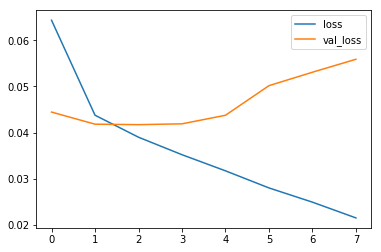

In [60]:
%matplotlib inline
pd.DataFrame(hist.history).drop(['acc', 'val_acc'], axis=1).plot()

In [67]:
model.load_weights('../models/GRU_pooling_att-03.h5')

In [68]:
y_pred = model.predict(X_val, verbose=1)
roc_auc_score(y_val, y_pred)

7979/7979 [==============================] - 11s 1ms/step


0.9870584633776445

In [69]:
y_pred = model.predict(X_test, batch_size=1024, verbose=True)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('GRU_pooling_att.csv', index=False)

153164/153164 [==============================] - 18s 116us/step


In [72]:
features = pd.DataFrame(columns=submission.columns)
features['id'] = train.id

In [74]:
features[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = model.predict(X, batch_size=1014, verbose=1)

159571/159571 [==============================] - 18s 111us/step


In [75]:
features.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,0.000674319,1.87721e-05,0.000171977,1.51876e-05,7.7457e-05,1.94247e-05
1,000103f0d9cfb60f,0.000911014,3.11073e-05,0.000208484,3.59529e-05,0.000130883,3.9355e-05
2,000113f07ec002fd,0.000978641,2.6564e-05,0.000258425,2.97287e-05,0.000145068,2.49281e-05
3,0001b41b1c6bb37e,0.00105188,2.96333e-05,0.000463428,6.10375e-05,0.000252591,3.7953e-05
4,0001d958c54c6e35,0.0374333,0.00035993,0.00407036,0.00167597,0.00852164,0.000506446


In [76]:
features.to_csv('../data/features/features_GRU_pooling_att.csv', index=False)